In [1]:
%aiida
from BigDFT import Datasets as D,Inputfiles as I, AiidaCalculator as C
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
benchmarks_path="/home/aiida/Irene/"
filename="monomer.pdb"

from BigDFT.IO import read_pdb
sys = read_pdb(open(filename))

charge = -3

nodelist=[8,16,32,64]
mpilist=[16]
omplist=[8]

In [3]:
#Limit nb of iterations for this set
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_xc("PBE")
inp.set_hgrid(0.4)
inp.charge(charge)
inp["import"] = "linear"
inp['lin_general'] = {'calc_dipole' : True}
inp['perf'] = {'check_sumrho': 0, 'check_overlap': 0}

In [4]:
benchData=D.Dataset(label='bench',input=inp, posinp=sys.get_posinp(), queue_name='rome', asynchronous=True)

In [5]:
#append MPi and OMP
for nodes in nodelist:
    for mpi in mpilist:
        for omp in omplist:
            wtime=int(30*60*(48.0/nodes))
            print(str(wtime)+" max walltime for "+str(nodes)+" nodes")
            code=C.AiidaCalculator(code="bigdft@irene2",num_machines=nodes,mpiprocs_per_machine=mpi,omp=omp, walltime=wtime)
            id={'name':'monomer', 'nodes':nodes,'mpi':mpi,'omp':omp}
            benchData.append_run(id=id,runner=code)



10800 max walltime for 8 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, uuid: ae6aeea2-26f4-4dc4-9f83-a4ff2667a644 with 8 machine(s) , 16 processes per machine, and 8 cores per process
5400 max walltime for 16 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, uuid: ae6aeea2-26f4-4dc4-9f83-a4ff2667a644 with 16 machine(s) , 16 processes per machine, and 8 cores per process
2700 max walltime for 32 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, uuid: ae6aeea2-26f4-4dc4-9f83-a4ff2667a644 with 32 machine(s) , 16 processes per machine, and 8 cores per process
1350 max walltime for 64 nodes
Initialize an Aiida Calculator for Remote code 'bigdft' on irene2, pk: 146, uuid: ae6aeea2-26f4-4dc4-9f83-a4ff2667a644 with 64 machine(s) , 16 processes per machine, and 8 cores per process


In [6]:
def get_time(DS):
    from os import path as p
    from futile import Time as T
    datadir=DS.fetch_results(attribute='data_directory')
    run_dir=DS.get_global_option('run_dir')
    time_files=[ p.join(run_dir,d,'time-'+n+'.yaml') for d,n in zip(datadir,DS.names)]
    return T.TimeData(*time_files)

In [7]:
tt=benchData.run()

Creating the yaml input file "./mpi:16,name:monomer,nodes:8,omp:8.yaml"
Creating the yaml input file "./mpi:16,name:monomer,nodes:16,omp:8.yaml"
Creating the yaml input file "./mpi:16,name:monomer,nodes:32,omp:8.yaml"
Creating the yaml input file "./mpi:16,name:monomer,nodes:64,omp:8.yaml"


Wait for completion of all jobs.

In [8]:
def wait_ds(DS):
    from IPython.display import display, clear_output

    running=len(DS.results)
    while(running!=0):

        import time
        time.sleep(1)
        running=len(DS.results)
        for c in DS.results:
            pk=DS.results[c]['node'].pk
            node=load_node(pk)
            if(node.is_finished):
                running-=1
                #print(node.is_finished_ok)
        clear_output(wait=True)
        display(str(running)+" processes still running")


Collect the logfiles

In [9]:
def get_logfiles(DS):
    logfiles={}
    for c in DS.results:
        print(DS.results[c]['node'].pk)
        try:
            logfiles[c]=DS.calculators[0]['calc'].get_logs(DS.results[c]['node'].pk,DS.names[c])
        except:
            logfiles[c]=DS.results[c]
            print("no logfile for "+ str(c))
    return logfiles

In [10]:
%%notify
wait_ds(benchData)

'0 processes still running'

<IPython.core.display.Javascript object>

In [11]:
logfiles=get_logfiles(benchData)

252
setting data dir to /home/aiida/.aiida/repository/default/repository/node/09/c9/e3ff-ac50-4982-ad8c-56e0732ec792/path
256
setting data dir to /home/aiida/.aiida/repository/default/repository/node/4b/c5/088d-d6fc-4b73-8aec-c5169cf789c2/path
260
setting data dir to /home/aiida/.aiida/repository/default/repository/node/c0/11/85be-1bc7-4c05-985e-387a0e189429/path
264
setting data dir to /home/aiida/.aiida/repository/default/repository/node/b6/5d/9d50-5576-46df-a407-bc65d048a8db/path


In [12]:
#WARNING : IRREVERSIBLE ! save results first
savedresults=benchData.results
benchData.results=logfiles

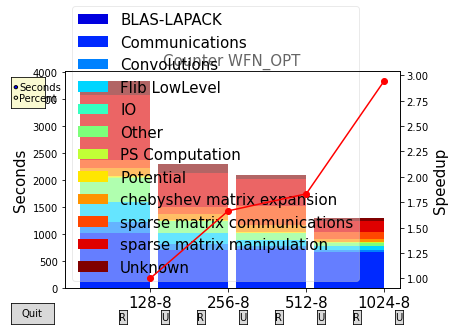

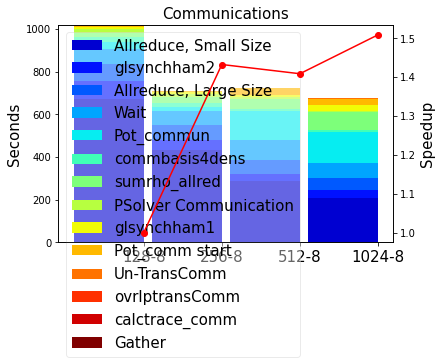

Channel <Channel number=1 CLOSED conn=<TornadoConnection CLOSED transport=None params=<ConnectionParameters host=127.0.0.1 port=5672 virtual_host=/ ssl=False>>> closed: No activity or too many missed heartbeats in the last 60 seconds
Channel <Channel number=2 CLOSED conn=<TornadoConnection CLOSED transport=None params=<ConnectionParameters host=127.0.0.1 port=5672 virtual_host=/ ssl=False>>> closed: No activity or too many missed heartbeats in the last 60 seconds
Channel <Channel number=3 CLOSED conn=<TornadoConnection CLOSED transport=None params=<ConnectionParameters host=127.0.0.1 port=5672 virtual_host=/ ssl=False>>> closed: No activity or too many missed heartbeats in the last 60 seconds
Channel <Channel number=4 CLOSED conn=<TornadoConnection CLOSED transport=None params=<ConnectionParameters host=127.0.0.1 port=5672 virtual_host=/ ssl=False>>> closed: No activity or too many missed heartbeats in the last 60 seconds
10/12/2020 11:38:02 PM <8669> tornado.application: [ERROR] Futur

In [14]:
%matplotlib inline
import sys
import futile
from futile import Time
tt=get_time(benchData)
tt2=tt.inspect_category("Communications")